<a href="https://colab.research.google.com/github/AndreaTribotti/project/blob/main/Furlani_Serfilippi_Tribotti_ml_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code to load the dataset

In [ ]:
!pip install -U "datasets==3.6.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 13.3 MB/s eta 0:00:00
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0


In [ ]:
import pandas as pd
import numpy as np
import gdown
import matplotlib.pyplot as plt
import copy
import math

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, f1_score

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
!pip install torchinfo
from torchinfo import summary

# **Dataset Preparation**

In [ ]:
### YOU MUST NOT CHANGE THIS CELL! ###

from datasets import load_dataset

full_dataset = load_dataset("skeskinen/TinyStories-GPT4", split="train")
full_dataset = full_dataset.remove_columns([c for c in full_dataset.column_names if c not in ["story", "features"]])
assert len(full_dataset) == 2745100

splits = full_dataset.train_test_split(test_size=10000, seed=42, shuffle=True)

train_dataset = splits["train"]
test_dataset  = splits["test"]

assert len(train_dataset) == 2735100
assert len(test_dataset)  == 10000

assert train_dataset[0]["story"][:33] == "One day, a little girl named Lily"
assert train_dataset[0]["features"] == ["Dialogue", "Conflict"]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/554 [00:00<?, ?B/s]

data/train-00000-of-00008-c63ccd5d5290f4(…):   0%|          | 0.00/194M [00:00<?, ?B/s]

data/train-00001-of-00008-478199d8ac0449(…):   0%|          | 0.00/194M [00:00<?, ?B/s]

data/train-00002-of-00008-9b868f59be94d8(…):   0%|          | 0.00/194M [00:00<?, ?B/s]

data/train-00003-of-00008-d183cca02834cd(…):   0%|          | 0.00/194M [00:00<?, ?B/s]

data/train-00004-of-00008-5f8ac0bb66de58(…):   0%|          | 0.00/194M [00:00<?, ?B/s]

data/train-00005-of-00008-e8c22c3e776b87(…):   0%|          | 0.00/194M [00:00<?, ?B/s]

data/train-00006-of-00008-941f57106aca33(…):   0%|          | 0.00/194M [00:00<?, ?B/s]

data/train-00007-of-00008-771d8aa2d5ce5c(…):   0%|          | 0.00/194M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2745100 [00:00<?, ? examples/s]

In [ ]:
import random
from sklearn.model_selection import train_test_split

random.seed(42)
n=250000 #number of samples
TAGS=["BadEnding", "Conflict", "Dialogue", "Foreshadowing", "MoralValue", "Twist"]

subset_indices = random.sample(range(len(train_dataset)), n)

# Create the subset that will be used to build the vocabulary
vocab_subset = train_dataset.select(subset_indices)

# Split the training set into train_subset_new and validation_subset
random.seed(1)
subset_indices_1 = random.sample(range(len(train_dataset)), n)
train_subset = train_dataset.select(subset_indices_1)
split = train_subset.train_test_split(test_size=0.2, seed=1)
train_subset_new = split["train"]
validation_subset = split["test"]

In [ ]:
# Here we print the first example of the train dataset

from pprint import pprint
pprint(train_dataset[0])

{'features': ['Dialogue', 'Conflict'],
 'story': 'One day, a little girl named Lily went for a walk with her mom. '
          'They saw a big cliff near the water. Lily was fearful and did not '
          "want to go near the cliff. She held her mom's hand tight.\n"
          '"Mom, I am scared," Lily said. Her mom looked at her and smiled. '
          '"It\'s okay to be scared, but I will tell you a secret. When I am '
          'scared, I take a deep breath and count to three. Then, I feel '
          'better."\n'
          'Lily tried what her mom said. She took a deep breath and counted to '
          'three. She felt better and was not as scared. Then, a big bird flew '
          'by and almost hit Lily. She was scared again, but her mom was there '
          'to help her.\n'
          '"Remember what I told you, Lily. Take a deep breath and count to '
          'three," her mom said. Lily did it again, and she felt better. They '
          'walked away from the cliff, and Lily wa

In [ ]:
import numpy as np

def encode_tags_fast(tag_matrix, tag_list):
    """
    tag_matrix: list of lists of tags for each story, shape [n, ?]
    tag_list: list of all possible tags

    Returns: multi-hot matrix [n, len(tag_list)]
    """
    n = len(tag_matrix)
    num_tags = len(tag_list)
    tags_multi_hot = np.zeros((n, num_tags), dtype=np.float32)

    for j, tag in enumerate(tag_list):
        tags_multi_hot[:, j] = np.array([tag in story_tags for story_tags in tag_matrix], dtype=np.float32)

    return tags_multi_hot


# **First model**
A multilabel logistic regression model, used to perform independent binary classification for each of the six labels

In [ ]:
# Extract texts and multi-hot encoded tags
X_text = [item['story'] for item in train_subset_new]
y_train_multi = encode_tags_fast([item['features'] for item in train_subset_new], TAGS)

X_test_text = [item['story'] for item in test_dataset]
y_test_multi = encode_tags_fast([item['features'] for item in test_dataset], TAGS)

# Convert text into numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))  # unigram + bigram
X_train_tfidf = vectorizer.fit_transform(X_text)
X_test_tfidf = vectorizer.transform(X_test_text)

# Logistic Regression with OneVsRestClassifier
base_clf = LogisticRegression(max_iter=10000,  class_weight="balanced")
model = OneVsRestClassifier(base_clf)


## First model training and prediction

In [ ]:
model.fit(X_train_tfidf, y_train_multi)

# Predictions
y_pred_multi = model.predict(X_test_tfidf)

## First model evaluation

In [ ]:
accuracies = [(y_pred_multi[:, i] == y_test_multi[:, i]).mean() for i in range(len(TAGS))]
for i, acc in enumerate(accuracies):
    print(f"Accuracy tag {TAGS[i]}: {acc*100:.2f}%")

#Precision, Recall and F1 per tag
precisions = []
recalls = []
f1_scores = []

for i in range(len(TAGS)):
    p = precision_score(y_test_multi[:, i], y_pred_multi[:, i], zero_division=0)
    r = recall_score(y_test_multi[:, i], y_pred_multi[:, i], zero_division=0)
    f1s = f1_score(y_test_multi[:, i], y_pred_multi[:, i], zero_division=0)

    precisions.append(p)
    recalls.append(r)
    f1_scores.append(f1s)

    print(f"Tag {TAGS[i]} -> Precision: {p:.4f}, Recall: {r:.4f}, F1: {f1s:.4f}")

# Averages
print("\n--- AVARAGES ---")
print(f"Average Accuracy: {np.mean(accuracies)*100:.2f}%")
print(f"Average Precision: {np.mean(precisions):.4f}")
print(f"Average Recall: {np.mean(recalls):.4f}")
print(f"Average F1: {np.mean(f1_scores):.4f}")
print(f"Average Accuracy: {np.mean(accuracies)*100:.2f}%")
print(f"Average F1: {np.mean(f1_scores):.4f}")

Accuracy tag BadEnding: 96.32%
Accuracy tag Conflict: 79.73%
Accuracy tag Dialogue: 89.87%
Accuracy tag Foreshadowing: 80.36%
Accuracy tag MoralValue: 95.53%
Accuracy tag Twist: 92.88%
Tag BadEnding -> Precision: 0.7213, Recall: 0.9610, F1: 0.8241
Tag Conflict -> Precision: 0.2845, Recall: 0.7993, F1: 0.4197
Tag Dialogue -> Precision: 0.9156, Recall: 0.8985, F1: 0.9070
Tag Foreshadowing -> Precision: 0.2961, Recall: 0.7721, F1: 0.4281
Tag MoralValue -> Precision: 0.7118, Recall: 0.9525, F1: 0.8148
Tag Twist -> Precision: 0.7755, Recall: 0.9022, F1: 0.8340

--- AVARAGES ---
Average Accuracy: 89.11%
Average Precision: 0.6175
Average Recall: 0.8809
Average F1: 0.7046
Average Accuracy: 89.11%
Average F1: 0.7046


# **Second model**
A Transformer-based model for multilabel text classification

## Build vocabulary

In [ ]:
import re

# Pattern:  words, numbers and punctuation characters
pattern = r"\w+|[^\w\s]"

# Loop over the first n stories in the subset to extract tokens which will be used to build the vocabulary
vocab_set = set()

for i in range(n):
    tokens = re.findall(pattern, vocab_subset[i]['story'].lower())
    vocab_set.update(tokens)

# Special tokens are defined to manage padding and unknown words
PAD_TOKEN = '[PAD]'
UNK_TOKEN = '[UNK]'

# Create the vocabulary
vocab_set = [PAD_TOKEN, UNK_TOKEN] + list(sorted(vocab_set))
token_to_index = {token: idx for idx, token in enumerate(vocab_set)}

print("Vocabulary:", token_to_index)
print("Number of tokens:", len(token_to_index))

Vocabulary: {'[PAD]': 0, '[UNK]': 1, '!': 2, '"': 3, '#': 4, '$': 5, '%': 6, '&': 7, "'": 8, '(': 9, ')': 10, '*': 11, '+': 12, ',': 13, '-': 14, '.': 15, '/': 16, '0': 17, '1': 18, '10': 19, '100': 20, '10p': 21, '11': 22, '12': 23, '123': 24, '1234': 25, '123s': 26, '13': 27, '15': 28, '16': 29, '1776': 30, '18': 31, '180': 32, '1950': 33, '1978': 34, '2': 35, '20': 36, '2005': 37, '20th': 38, '21': 39, '21st': 40, '23': 41, '25': 42, '27cm': 43, '28': 44, '3': 45, '30': 46, '31': 47, '312': 48, '32': 49, '35': 50, '36': 51, '360': 52, '37': 53, '38': 54, '3rd': 55, '4': 56, '40': 57, '400': 58, '5': 59, '50': 60, '512': 61, '555': 62, '5th': 63, '6': 64, '60': 65, '7': 66, '73': 67, '76': 68, '78': 69, '8': 70, '80': 71, '9': 72, '911': 73, '93': 74, '99': 75, ':': 76, ';': 77, '<': 78, '=': 79, '>': 80, '?': 81, '[': 82, '\\': 83, ']': 84, '`': 85, 'a': 86, 'aa': 87, 'aaa': 88, 'aaaaaaah': 89, 'aaaah': 90, 'aaaahhhh': 91, 'aaah': 92, 'aaahed': 93, 'aah': 94, 'aahed': 95, 'aardvark'

Tokenization, Encoding and Padding of stories

In [ ]:
import numpy as np
import re

# Number of tokens per story
n_tokens = 256

def encode(x):
    """
    the function encode convert a list of tokens to their corresponding indices in the vocabulary.
    If a token is not in the vocabulary, it is replaced by the UNK_TOKEN
    """
    return [token_to_index.get(token, token_to_index[UNK_TOKEN])  for token in x]


def truncate_and_pad(sequence, n_tokens=256):
    """
    Truncate a sequence to n_tokens.
    Add padding tokens if the sequence is shorter.
    """
    if len(sequence) < n_tokens:
        sequence = sequence + [PAD_TOKEN] * (n_tokens - len(sequence))
    else:
        sequence = sequence[:n_tokens]
    return sequence


def encode_multiple(data):
    n = len(data)
    X = []
    for i in range(n):
        words = re.findall(pattern, data[i]['story'].lower())
        X.append(encode(truncate_and_pad(words, n_tokens)))
    return X

Encoding of tags

In [ ]:
def build_dataset(data):
    encoded_data = encode_multiple(data)
    encoded_tag = encode_tags_fast(data[:]['features'], TAGS)
    return TensorDataset(torch.tensor(encoded_data), torch.tensor(encoded_tag))

train_dataset = build_dataset(train_subset_new)
val_dataset = build_dataset(validation_subset)
test_dataset = build_dataset(test_dataset)

## Second model definition

In [ ]:
# Model hyperparameters
VOCAB_SIZE = len(token_to_index)
EMBEDDING_DIM = 128
HIDDEN_DIM = 128
NUM_HEADS = 4
NUM_TAGS = 6
batch_size=128


encoder_layer = nn.TransformerEncoderLayer(
    d_model=EMBEDDING_DIM,
    nhead=NUM_HEADS,
    dim_feedforward=HIDDEN_DIM,
    batch_first=True,
)


class LearnedPositionalEmbedding(nn.Module):
    """
    Adds a trainable position vector to each token embedding.
    Expects input shape [B, L, D] (batch_first).
    """
    def __init__(self, max_length: int, dim: int):
        super().__init__()
        self.pos_emb = nn.Embedding(max_length, dim)

    def forward(self, x):                   # x: [B, L, D]
        L = x.size(1)
        pos = torch.arange(L, device=x.device)          # [L]
        pos = pos.unsqueeze(0)                          # [1, L]
        return x + self.pos_emb(pos)                    # broadcast add

class MaxPooling(nn.Module):
    def forward(self, x):   # x: [B, L, D]
        return x.max(dim=1).values  # output: [B, D]


# Full model
model = nn.Sequential(
    nn.Embedding(VOCAB_SIZE, EMBEDDING_DIM, padding_idx=token_to_index[PAD_TOKEN]),
    LearnedPositionalEmbedding(n_tokens, EMBEDDING_DIM),
    nn.TransformerEncoder(encoder_layer, num_layers=1),
    MaxPooling(),
    nn.Linear(EMBEDDING_DIM, NUM_TAGS),
)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Total parameters: 2,442,886
Trainable parameters: 2,442,886


## Training and evaluation functions

In [ ]:
"""
Define the training function
"""

def train(model, train_dataset, val_dataset, optimizer, batch_size, epochs, device):
    model.to(device)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    loss_fn = nn.BCEWithLogitsLoss() # Multi-label loss

    for epoch in range(epochs):
      print(f"--- Epoch {epoch+1} ---")
      model.train()
      losses = []
      for batch_idx, (data, target) in enumerate(train_loader):

          data, target = data.to(device), target.to(device).float()
          optimizer.zero_grad()
          output = model(data)
          loss = loss_fn(output, target)
          loss.backward()
          optimizer.step()
          losses.append(loss.item())
      training_loss = np.mean(losses)

      # VALIDATION
      validation_loss, val_accuracies = evaluate(model, val_loader, device)
      avg_val_acc = sum(val_accuracies) / len(val_accuracies)

      # PRINT
      print(f"Training loss = {training_loss:.4f} | Validation loss = {validation_loss:.4f}")
      print()

def evaluate(model, loader, device, threshold=0.5):
    """
    Evaluate the model on the validation set.
    Return the avarage loss and accuracy
    """

    model.to(device)
    model.eval()
    total_loss = 0
    loss_fn = nn.BCEWithLogitsLoss()

    all_preds, all_targets = [], []

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device).float()
            output = model(data)
            total_loss += loss_fn(output, target).item()

            preds = (torch.sigmoid(output) > threshold).int()
            all_preds.append(preds.cpu())
            all_targets.append(target.cpu().int())

    all_preds = torch.cat(all_preds, dim=0).numpy()
    all_targets = torch.cat(all_targets, dim=0).numpy()

    # Accuracy, precision, recall, F1 score per tag
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []

    for i in range(all_targets.shape[1]):
        acc_i = (all_preds[:, i] == all_targets[:, i]).mean()
        accuracies.append(acc_i)

        p = precision_score(all_targets[:, i], all_preds[:, i], zero_division=0)
        r = recall_score(all_targets[:, i], all_preds[:, i], zero_division=0)
        f = f1_score(all_targets[:, i], all_preds[:, i], zero_division=0)

        precisions.append(p)
        recalls.append(r)
        f1_scores.append(f)

        print(f"Label {i}: Accuracy={acc_i*100:.2f}%, Precision={p:.3f}, Recall={r:.3f}, F1={f:.3f}")

    # Avarage accuracy, avarage precison, avarage recall and avarage F1 score
    avg_acc = sum(accuracies) / len(accuracies)
    avg_prec = sum(precisions) / len(precisions)
    avg_rec = sum(recalls) / len(recalls)
    avg_f1 = sum(f1_scores) / len(f1_scores)

    print(f"Average Accuracy: {avg_acc*100:.2f}%")
    print(f"Average Precision: {avg_prec:.3f}")
    print(f"Average Recall: {avg_rec:.3f}")
    print(f"Average F1: {avg_f1:.3f}")
    return total_loss / len(loader), accuracies

## Second model training

The following two cells are commented out because, to speed up training, we have already trained the model and uploaded the weights to Drive.

In [ ]:
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# train(model, train_dataset, val_dataset, optimizer, batch_size=128, epochs=5, device='cuda')

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# save_path = "/content/drive/MyDrive/Colab_Notebooks"

# torch.save(model.state_dict(), f"{save_path}/Pesi_Sara.pth")

We download the weights of the trained model from Drive.

In [ ]:
!pip install -q gdown

import gdown
import zipfile
import os

url = "https://drive.google.com/file/d/1CzcwOsdImZBsWGNP5-sRlFK4GoFVqjO9/view?usp=drive_link"

downloaded_file = "second_model.zip"

# --- Download the file ---
gdown.download(f"https://drive.google.com/uc?id={"1CzcwOsdImZBsWGNP5-sRlFK4GoFVqjO9"}", downloaded_file, quiet=False)

# --- extract the ZIP file ---
output_folder = "second_model"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

with zipfile.ZipFile(downloaded_file, 'r') as zip_ref:
    zip_ref.extractall(output_folder)

subfolder = os.path.join("second_model", "pesi_second_model")
files = os.listdir(subfolder)

print(f"Download completed and folder extracted to '{output_folder}'")
print("Contents of second_model:", os.listdir(output_folder))
print("Contents of pesi_second_model:",files)

Downloading...
From: https://drive.google.com/uc?id=1CzcwOsdImZBsWGNP5-sRlFK4GoFVqjO9
To: /content/second_model.zip
100%|██████████| 9.05M/9.05M [00:00<00:00, 32.8MB/s]

Download completed and folder extracted to 'second_model'
Contents of second_model: ['pesi_second_model']
Contents of pesi_second_model: ['Pesi_Sara.pth']


In [ ]:
model.load_state_dict(torch.load("second_model/pesi_second_model/Pesi_Sara.pth", map_location=torch.device("cpu")))

<All keys matched successfully>

## Second model evaluation

In [ ]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)
print("--- Test on unseen data ---")
print()
test_loss, test_accuracies = evaluate(model, test_loader, device='cuda')

avg_test_acc = sum(test_accuracies) / len(test_accuracies)
print(f"Test Loss = {test_loss:.4f}")
print(f"Test Average Accuracy = {avg_test_acc*100:.2f}%")

--- Test on unseen data ---

Label 0: Accuracy=97.56%, Precision=0.847, Recall=0.889, F1=0.867
Label 1: Accuracy=92.19%, Precision=0.641, Recall=0.337, F1=0.442
Label 2: Accuracy=90.95%, Precision=0.880, Recall=0.967, F1=0.922
Label 3: Accuracy=91.84%, Precision=0.707, Recall=0.244, F1=0.362
Label 4: Accuracy=96.48%, Precision=0.901, Recall=0.740, F1=0.813
Label 5: Accuracy=94.93%, Precision=0.892, Recall=0.847, F1=0.869
Average Accuracy: 93.99%
Average Precision: 0.811
Average Recall: 0.671
Average F1: 0.712
Test Loss = 0.1604
Test Average Accuracy = 93.99%


# **Third model**
We perform fine-tuning of the DistilBERT model for text classification.

## distilbert-base-uncased model

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments

# Load the pre-trained model and the tokenizer
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6, problem_type="multi_label_classification")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Let's simulate a batch of 1 sequence with 256 tokens
batch_size = 1
sequence_length = 256

# Input tensors
input_ids = torch.randint(0, 30522, (batch_size, sequence_length), dtype=torch.long)   # 30522 = size of DistilBERT's vocabulary
attention_mask = torch.ones((batch_size, sequence_length), dtype=torch.long)

# summary
summary(
    model,
    input_data=(input_ids, attention_mask),
    dtypes=[torch.long, torch.long],
    device='cpu'
    )

Layer (type:depth-idx)                                  Output Shape              Param #
DistilBertForSequenceClassification                     [1, 6]                    --
├─DistilBertModel: 1-1                                  [1, 256, 768]             --
│    └─Embeddings: 2-1                                  [1, 256, 768]             --
│    │    └─Embedding: 3-1                              [1, 256, 768]             23,440,896
│    │    └─Embedding: 3-2                              [1, 256, 768]             393,216
│    │    └─LayerNorm: 3-3                              [1, 256, 768]             1,536
│    │    └─Dropout: 3-4                                [1, 256, 768]             --
│    └─Transformer: 2-2                                 [1, 256, 768]             --
│    │    └─ModuleList: 3-5                             --                        42,527,232
├─Linear: 1-2                                           [1, 768]                  590,592
├─Dropout: 1-3                 

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Total parameters: 66,958,086
Trainable parameters: 66,958,086


## Tokenization

In [ ]:
def tokenize_function(examples):
    return tokenizer(
        examples["story"],
        padding="max_length",   # uniforma le lunghezze
        truncation=True,        # taglia se troppo lunga
        max_length=256          # lunghezza massima 512
    )

The following cell is commented out because, to speed up workflow, we have already tokanized the data and uploaded the tokanized sets to Drive.

In [ ]:
# We tokenize the data
# tokenized_train = train_subset_new.map(tokenize_function, batched=True)
# tokenized_val   = validation_subset.map(tokenize_function, batched=True)
# tokenized_test = test_dataset.map(tokenize_function, batched=True)

# We set the format to Torch
# tokenized_train.set_format(type="torch", columns=["input_ids", "attention_mask"])
# tokenized_val.set_format(type="torch", columns=["input_ids", "attention_mask"])
# tokenized_test.set_format(type="torch", columns=["input_ids", "attention_mask"])

# from google.colab import drive
# drive.mount('/content/drive')

# save_path = "/content/drive/MyDrive/Colab_Notebooks/tokenized_dataset"

# tokenized_train.save_to_disk(f"{save_path}/train")
# tokenized_val.save_to_disk(f"{save_path}/val")
# tokenized_test.save_to_disk(f"{save_path}/test")

We download the tokanized datasets from Drive.

In [ ]:
url = "https://drive.google.com/file/d/1oovVts5r5Vav-Q1vb6-TorFP5diyuymu/view?usp=drive_link"

downloaded_file = "folder_tokenized_dataset.zip"

# --- Download the file ---
gdown.download(f"https://drive.google.com/uc?id={"1oovVts5r5Vav-Q1vb6-TorFP5diyuymu"}", downloaded_file, quiet=False)

# --- extract the ZIP file ---
output_folder = "folder_tokenized_dataset"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

with zipfile.ZipFile(downloaded_file, 'r') as zip_ref:
    zip_ref.extractall(output_folder)

subfolder = os.path.join("folder_tokenized_dataset", "tokenized_dataset")
files = os.listdir(subfolder)

print(f"Download completed and folder extracted to '{output_folder}'")
print("Contents of folder_tokenized_dataset:", os.listdir(output_folder))
print("Contents of tokenized_dataset:",files)

Downloading...
From (original): https://drive.google.com/uc?id=1oovVts5r5Vav-Q1vb6-TorFP5diyuymu
From (redirected): https://drive.google.com/uc?id=1oovVts5r5Vav-Q1vb6-TorFP5diyuymu&confirm=t&uuid=31a58ffa-ace6-46e0-b8cb-99303843bb2a
To: /content/folder_tokenized_dataset.zip
100%|██████████| 126M/126M [00:02<00:00, 47.8MB/s]


Download completed and folder extracted to 'folder_tokenized_dataset'
Contents of folder_tokenized_dataset: ['tokenized_dataset']
Contents of tokenized_dataset: ['val', 'train', 'test']


In [ ]:
for subset in ["train", "val", "test"]:
    folder = os.path.join("folder_tokenized_dataset", "tokenized_dataset", subset)
    print(f"{subset} contains: {os.listdir(folder)}")

train contains: ['state.json', 'data-00000-of-00001.arrow', 'dataset_info.json']
val contains: ['state.json', 'data-00000-of-00001.arrow', 'dataset_info.json']
test contains: ['state.json', 'data-00000-of-00001.arrow', 'dataset_info.json']


In [ ]:
from datasets import load_from_disk

base_folder = os.path.join("folder_tokenized_dataset", "tokenized_dataset")

train_path = os.path.join(base_folder, "train")
val_path = os.path.join(base_folder, "val")
test_path = os.path.join(base_folder, "test")

# --- loading the tokenized datasets ---
tokenized_train = load_from_disk(train_path)
tokenized_val = load_from_disk(val_path)
tokenized_test = load_from_disk(test_path)

In [ ]:
print("Number of examples in tokenized_train:", len(tokenized_train))
print("Number of examples in tokenized_val:", len(tokenized_val))

# Here we print the first example of the training subset and its corresponding tokenized version
pprint(train_subset_new[0])
pprint(tokenized_train[0])

Number of examples in tokenized_train: 200000
Number of examples in tokenized_val: 50000
{'features': ['Dialogue', 'Foreshadowing'],
 'story': 'Once upon a time, there was a little girl named Lily. Lily liked to '
          'find interesting stuff in her house. One day, she found a big, old '
          'box in her room. Lily was very excited.\n'
          'Lily\'s mom said, "Lily, do not leave the box open. It has special '
          'stuff inside." Lily said, "Okay, Mom," but she really wanted to see '
          'what was inside. When her mom went away, Lily opened the box. '
          'Inside, she found a pretty, red hat.\n'
          'Lily put on the hat and went outside to play. Suddenly, the hat '
          'started to talk. "Thank you for letting me out of the box," said '
          'the hat. "I can make your day fun!" The hat showed Lily how to fly '
          'in the sky, and they had a great day together. When it was time to '
          'go home, Lily knew she had found the mo

We convert story tags into a binary vector where 1 indicates the tag is present and 0 means absent.

In [ ]:
TAGS = ["BadEnding", "Conflict", "Dialogue", "Foreshadowing", "MoralValue", "Twist"]

# We create a mapping from each tag to a unique index
tag2id = {tag: i for i, tag in enumerate(TAGS)}
print(tag2id)

def encode_labels(features):
    labels = [0] * len(TAGS)
    for tag in features:
        if tag in tag2id:
            labels[tag2id[tag]] = 1
    return torch.tensor(labels, dtype=torch.float)

{'BadEnding': 0, 'Conflict': 1, 'Dialogue': 2, 'Foreshadowing': 3, 'MoralValue': 4, 'Twist': 5}


This following cell is commented out because, in order to speed up the workflow, the encoded tag vectors have already been pre-computed and uploaded to Drive.

In [ ]:
# tokenized_train = tokenized_train.map(lambda x: {"labels": encode_labels(x["features"])})
# tokenized_val   = tokenized_val.map(lambda x: {"labels": encode_labels(x["features"])})
# tokenized_test   = tokenized_test.map(lambda x: {"labels": encode_labels(x["features"])})

# We set the format to Torch
# tokenized_train.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
# tokenized_val.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# from google.colab import drive
# drive.mount('/content/drive')

# save_path = "/content/drive/MyDrive/Colab_Notebooks/labelled_dataset"

# tokenized_train.save_to_disk(f"{save_path}/lab_train")
# tokenized_val.save_to_disk(f"{save_path}/lab_val")
# tokenized_test.save_to_disk(f"{save_path}/lab_test")

We download the encoded tag vectors from Drive.

In [ ]:
url = "https://drive.google.com/file/d/1ZsvBpvq9trbOLqMuxM7VECMLG1k_hbe3/view?usp=drive_link"

downloaded_file = "folder_labelled.zip"

# --- Download the file ---
gdown.download(f"https://drive.google.com/uc?id={"1ZsvBpvq9trbOLqMuxM7VECMLG1k_hbe3"}", downloaded_file, quiet=False)

# --- extract the ZIP file ---
output_folder = "folder_labelled"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

with zipfile.ZipFile(downloaded_file, 'r') as zip_ref:
    zip_ref.extractall(output_folder)

subfolder = os.path.join("folder_labelled", "labelled_dataset")
files = os.listdir(subfolder)

print(f"Download completed and folder extracted to '{output_folder}'")
print("Contents of folder_labelled:", os.listdir(output_folder))
print("Contents of labelled_dataset:",files)

Downloading...
From (original): https://drive.google.com/uc?id=1ZsvBpvq9trbOLqMuxM7VECMLG1k_hbe3
From (redirected): https://drive.google.com/uc?id=1ZsvBpvq9trbOLqMuxM7VECMLG1k_hbe3&confirm=t&uuid=6a9b40be-00d8-4821-976f-7325b2e57286
To: /content/folder_labelled.zip
100%|██████████| 127M/127M [00:01<00:00, 86.0MB/s]


Download completed and folder extracted to 'folder_labelled'
Contents of folder_labelled: ['labelled_dataset']
Contents of labelled_dataset: ['lab_test', 'lab_val', 'lab_train']


In [ ]:
for subset in ["lab_train", "lab_val", "lab_test"]:
    folder = os.path.join("folder_labelled", "labelled_dataset", subset)
    print(f"{subset} contains: {os.listdir(folder)}")

lab_train contains: ['state.json', 'data-00000-of-00001.arrow', 'dataset_info.json']
lab_val contains: ['state.json', 'data-00000-of-00001.arrow', 'dataset_info.json']
lab_test contains: ['state.json', 'data-00000-of-00001.arrow', 'dataset_info.json']


In [ ]:
base_folder = os.path.join("folder_labelled", "labelled_dataset")

train_path_lab = os.path.join(base_folder, "lab_train")
val_path_lab = os.path.join(base_folder, "lab_val")
test_path_lab = os.path.join(base_folder, "lab_test")

# --- loading the tokenized datasets ---
tokenized_train = load_from_disk(train_path_lab)
tokenized_val = load_from_disk(val_path_lab)
tokenized_test = load_from_disk(test_path_lab)

In [ ]:
# Here we print how the first example of the tokenized_train change
pprint(tokenized_train[0])

{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'input_ids': tensor([ 101, 2320, 2588, 1037, 2051, 1010, 2045, 2001, 1037, 2210, 2611, 2315,
        7094, 1012, 7094, 466

##Training and test evaluation

In [ ]:
def train(model, train_dataset, val_dataset, optimizer, batch_size, epochs, device):
    model.to(device)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    loss_fn = nn.BCEWithLogitsLoss()  # multi-label classification

    for epoch in range(epochs):
        print(f"--- Epoch {epoch+1} ---")
        model.train()
        losses = []

        for batch_idx, batch in enumerate(train_loader):
          # prepare data and labels
          inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
          labels = batch["labels"].to(device).float()

          optimizer.zero_grad()
          outputs = model(**inputs).logits  # HuggingFace models return an object, we need .logits
          loss = loss_fn(outputs, labels)

          loss.backward()
          optimizer.step()
          losses.append(loss.item())

        training_loss = np.mean(losses)

        # VALIDATION
        validation_loss, val_accuracies = evaluate(model, val_loader, device)
        avg_val_acc = sum(val_accuracies) / len(val_accuracies)

        # PRINT
        print(f"Training loss = {training_loss:.4f} | Validation loss = {validation_loss:.4f}")

def evaluate(model, loader, device, threshold=0.3):
    """
    Evaluate the model on the validation set.
    Return the average loss and accuracy per label.
    """
    model.to(device)
    model.eval()
    total_loss = 0
    loss_fn = nn.BCEWithLogitsLoss()

    all_preds, all_targets = [], []

    with torch.no_grad():
      for batch in loader:
        inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
        labels = batch["labels"].to(device).float()

        outputs = model(**inputs).logits
        total_loss += loss_fn(outputs, labels).item()

        preds = (torch.sigmoid(outputs) > threshold).int()
        all_preds.append(preds.cpu())
        all_targets.append(labels.cpu().int())

    all_preds = torch.cat(all_preds, dim=0).numpy()
    all_targets = torch.cat(all_targets, dim=0).numpy()

    # Accuracy, precision, recall, F1 score per tag
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []

    for i in range(all_targets.shape[1]):
      acc_i = (all_preds[:, i] == all_targets[:, i]).mean()
      accuracies.append(acc_i)

      p = precision_score(all_targets[:, i], all_preds[:, i], zero_division=0)
      r = recall_score(all_targets[:, i], all_preds[:, i], zero_division=0)
      f = f1_score(all_targets[:, i], all_preds[:, i], zero_division=0)

      precisions.append(p)
      recalls.append(r)
      f1_scores.append(f)

      print(f"Label {i}: Accuracy={acc_i*100:.2f}%, Precision={p:.3f}, Recall={r:.3f}, F1={f:.3f}")

    # Average metrics
    avg_acc = sum(accuracies) / len(accuracies)
    avg_prec = sum(precisions) / len(precisions)
    avg_rec = sum(recalls) / len(recalls)
    avg_f1 = sum(f1_scores) / len(f1_scores)

    print(f"Average Accuracy: {avg_acc*100:.2f}%")
    print(f"Average Precision: {avg_prec:.3f}, Average Recall: {avg_rec:.3f}, Average F1: {avg_f1:.3f}")

    return total_loss / len(loader), accuracies

The following two cells are commented out because, to speed up training, we have already trained the model and uploaded the weights to Drive.

In [ ]:
# Parameters
# batch_size = 64
# epochs = 5
# device = "cuda"

# Optimizer
# optimizer = Adam(model.parameters(), lr=0.0001)

# training
# train(model, tokenized_train, tokenized_val, optimizer, batch_size, epochs, device)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# save_path = "/content/drive/MyDrive/Colab_Notebooks"

# torch.save(model.state_dict(), f"{save_path}/model_weights.pth")

We download the weights of the trained model from Drive.

In [ ]:
url = "https://drive.google.com/file/d/1b6o8qy81VB2DFzOVReaI46ZEx-9dDkJw/view?usp=drive_link"

downloaded_file = "folder_PESI.zip"

# --- Download the file ---
gdown.download(f"https://drive.google.com/uc?id={"1b6o8qy81VB2DFzOVReaI46ZEx-9dDkJw"}", downloaded_file, quiet=False)

# --- extract the ZIP file ---
output_folder = "folder_PESI"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

with zipfile.ZipFile(downloaded_file, 'r') as zip_ref:
    zip_ref.extractall(output_folder)

subfolder = os.path.join("folder_PESI", "PESI")
files = os.listdir(subfolder)

print(f"Download completed and folder extracted to '{output_folder}'")
print("Contents of folder_PESI:", os.listdir(output_folder))
print("Contents of PESI:",files)

Downloading...
From (original): https://drive.google.com/uc?id=1b6o8qy81VB2DFzOVReaI46ZEx-9dDkJw
From (redirected): https://drive.google.com/uc?id=1b6o8qy81VB2DFzOVReaI46ZEx-9dDkJw&confirm=t&uuid=da075325-6767-42ec-8716-a90013f4a1f7
To: /content/folder_PESI.zip
100%|██████████| 247M/247M [00:02<00:00, 94.1MB/s]


Download completed and folder extracted to 'folder_PESI'
Contents of folder_PESI: ['PESI']
Contents of PESI: ['model_weights.pth']


In [ ]:
model.load_state_dict(torch.load("folder_PESI/PESI/model_weights.pth", map_location=torch.device("cpu")))

<All keys matched successfully>

We now test the model on unsee data.

In [ ]:
test_loader = torch.utils.data.DataLoader(tokenized_test, batch_size=64, shuffle=False)
print("--- Test on unseen data ---")
validation_loss, val_accuracies = evaluate(model,test_loader,device="cuda")

--- Test on unseen data ---
Label 0: Accuracy=98.66%, Precision=0.955, Recall=0.893, F1=0.923
Label 1: Accuracy=93.31%, Precision=0.688, Recall=0.495, F1=0.576
Label 2: Accuracy=92.52%, Precision=0.902, Recall=0.970, F1=0.934
Label 3: Accuracy=90.82%, Precision=0.517, Recall=0.553, F1=0.534
Label 4: Accuracy=97.40%, Precision=0.902, Recall=0.839, F1=0.869
Label 5: Accuracy=93.88%, Precision=0.786, Recall=0.951, F1=0.860
Average Accuracy: 94.43%
Average Precision: 0.791, Average Recall: 0.783, Average F1: 0.783


# **Result visualization**

Now we will plot one graph per model showing precision, recall, and F1-score for the six tags in the test set.

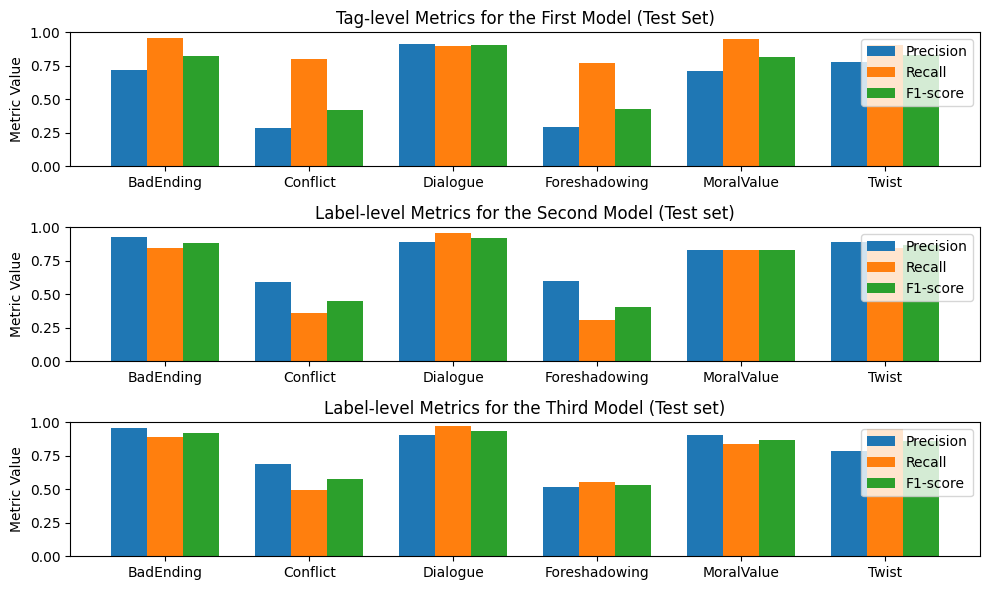

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# First Model
tags_A = ['BadEnding', 'Conflict', 'Dialogue', 'Foreshadowing', 'MoralValue', 'Twist']
precision_A = [0.7213, 0.2845, 0.9156, 0.2961, 0.7118, 0.7755]
recall_A = [0.9610, 0.7993, 0.8985, 0.7721, 0.9525, 0.9022]
f1_A = [0.8241, 0.4197, 0.9070, 0.4281, 0.8148, 0.8340]

# Second Model
tags_B = ['BadEnding', 'Conflict', 'Dialogue', 'Foreshadowing', 'MoralValue', 'Twist']
precision_B = [0.928, 0.593, 0.889, 0.599, 0.832, 0.888]
recall_B = [0.843, 0.362, 0.959, 0.309, 0.831, 0.849]
f1_B = [0.883, 0.450, 0.922, 0.407, 0.832, 0.868]

# Third Model
tags_C = ['BadEnding', 'Conflict', 'Dialogue', 'Foreshadowing', 'MoralValue', 'Twist']
precision_C = [0.955, 0.688, 0.902, 0.517, 0.902, 0.786]
recall_C = [0.893, 0.495, 0.970, 0.553, 0.839, 0.951]
f1_C = [0.923, 0.576, 0.934, 0.534, 0.869, 0.860]

# Plot
fig, axes = plt.subplots(3, 1, figsize=(10,6))

# First Model
x = np.arange(len(tags_A))
width = 0.25
axes[0].bar(x - width, precision_A, width, label='Precision')
axes[0].bar(x, recall_A, width, label='Recall')
axes[0].bar(x + width, f1_A, width, label='F1-score')
axes[0].set_xticks(x)
axes[0].set_xticklabels(tags_A)
axes[0].set_ylabel('Metric Value')
axes[0].set_ylim(0, 1)
axes[0].set_title('Tag-level Metrics for the First Model (Test Set)')
axes[0].legend()

# Second model
x = np.arange(len(tags_B))
axes[1].bar(x - width, precision_B, width, label='Precision')
axes[1].bar(x, recall_B, width, label='Recall')
axes[1].bar(x + width, f1_B, width, label='F1-score')
axes[1].set_xticks(x)
axes[1].set_xticklabels(tags_B)
axes[1].set_ylabel('Metric Value')
axes[1].set_ylim(0, 1)
axes[1].set_title('Label-level Metrics for the Second Model (Test set)')
axes[1].legend()

# Third model
x = np.arange(len(tags_C))
axes[2].bar(x - width, precision_C, width, label='Precision')
axes[2].bar(x, recall_C, width, label='Recall')
axes[2].bar(x + width, f1_C, width, label='F1-score')
axes[2].set_xticks(x)
axes[2].set_xticklabels(tags_C)
axes[2].set_ylabel('Metric Value')
axes[2].set_ylim(0, 1)
axes[2].set_title('Label-level Metrics for the Third Model (Test set)')
axes[2].legend()

plt.tight_layout()
plt.show()
